# Cutting-Edge project - Milliman


- Members: **Amal BACHA - Dalia BARBI - Khalil BATTIKH - Lucas RODRIGUEZ - Naïm SOUNI**
- Group 2
- Professional partner: **[Milliman](https://www.milliman.com/en/)**

*January 2023 - Present*

---

In [54]:
import numpy as np
import numpy.random as npr
import time
import warnings
import scipy
import pandas as pd
import matplotlib.pyplot as plt

# Silencing all warnings for a better UX
warnings.filterwarnings("ignore")

# Setting up a fixed random seed for experiment purposes
npr.seed(1)

## Interest rates modelling

### Vasicek

In [55]:
def OU_processes(years, timestep, num_sims, startRate, kappa, theta, sigma):
    """
    timestep has to be defined in years or a fraction of years
    e.g. 0.1 => 1/10th of a year; 2 => 2 years
    """
    times = np.arange(0,years+timestep,timestep)
    epsilon = np.random.normal(0, 1, (num_sims, len(times)-1))
    elt = 0.5 / kappa * (1.0 - np.exp (-2.0 * kappa * timestep))
    V = elt * sigma ** 2 
    sqrt_V = np.sqrt(V) 
    ou = np.zeros((num_sims, len(times)))
    ou[:,0] = startRate
    ou[:, 1:] = np.kron(sqrt_V, np.ones((num_sims, 1))) * epsilon
    for i in range(1, ou.shape[1]):
        ou[:, i] += theta * (1 - np.exp(-kappa * timestep))
        ou[:, i] += np.exp (-kappa * timestep) * ou[:, i-1]
    ou = pd.DataFrame(np.transpose(ou))
    ou.index = times
    return ou

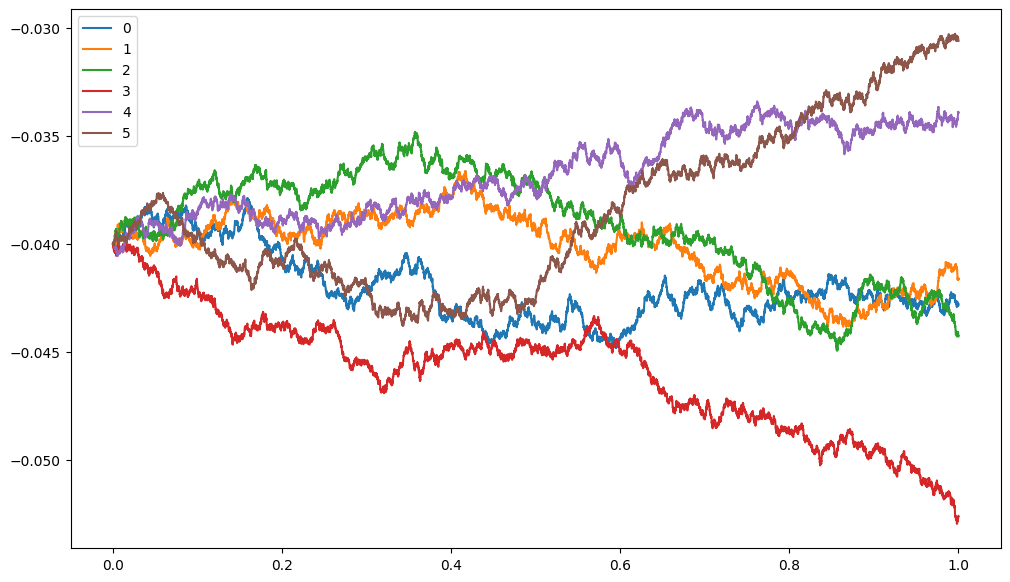

In [62]:
_ = OU_processes(1, 1e-4, 6, -0.04, 1e-3, 2e-2, 0.005).plot(figsize=(12, 7))

In [27]:
class VasicekModel:
    def __init__(self, kappa: float, theta: float, eta: float) -> None:
        """
        Default constructor in order to verify the validity of the parameters, and store them
        """
        # Verification
        assert kappa > 0
        
        # Storing variable
        self.kappa = kappa
        self.theta = theta
        self.eta = eta

In [41]:
# Default Vasicek model
dftVasicek = VasicekModel(1, 2, 3)
_MAX_STEPS = 1e5

In [42]:
# Vasicek (closed formula)

def sim_rates_vasicek_exact(m: VasicekModel = dftVasicek) -> np.ndarray:
    """  
    """
    pass

In [43]:
# Vasicek (Euler)

def sim_rates_vasicek_euler(m: VasicekModel = dftVasicek,
                            n: int = _MAX_STEPS) -> np.ndarray:
    """
    """
    pass

In [44]:
# Vasicek (Milstein)

def sim_rates_vasicek_milstein(m: VasicekModel = dftVasicek,
                               n: int = _MAX_STEPS) -> np.ndarray:
    """
    """
    pass

In [63]:
# Normality test (Shapiro-Wilk + Jarque-Bera)
TEST_THRESHOLD_ALPHA = 5e-2 # Threshold for p-value

# Definition of normality tests (Shapiro-Wilf + Jarque-Bera)
normtest_shapiro = lambda x: scipy.stats.shapiro(x).pvalue > TEST_THRESHOLD_ALPHA 
normtest_jarquebera = lambda x:scipy.stats.jarque_bera(x).pvalue > TEST_THRESHOLD_ALPHA

In [64]:
# Perform normality test

### Cox-Ingersoll-Ross (CIR)

### Hull & White (HW) $\diamond$ Extended Vasicek

## Equity modelling

### Black-Scholes model $\diamond$ <span style="background:red; color:white; padding: 2px 6px">Constant drift/Constant volatility</span>

### Black-Scholes model $\diamond$ <span style="background:red; color:white; padding: 2px 6px">Time-varying drift/Constant volatility</span>

### Black-Scholes model $\diamond$ <span style="background:red; color:white; padding: 2px 6px">Time-varying drift/Time-varying volatility</span>

## Analysis

### Distribution of $S_T$

### Computation of derivatives price

## Miscellaneous

### Simulation of the joint distribution $\Big(\int_0^T r_u \mathrm{d}u, S_T\Big) $

### Model refinement $\longrightarrow$ Constant to time-varying parameters

#### <u>Interest rates dynamics</u> $\leadsto$ <span style="background:gray; color:white; padding: 2px 6px">$t \longmapsto \theta(t)$ instead of $\theta \in \mathbb{R}^+$</span>

#### <u>Equity index dynamics</u> $\leadsto$ <span style="background:gray; color:white; padding: 2px 6px">$t \longmapsto \sigma(t)$ instead of $\sigma \in \mathbb{R}^+$</span>

---
**Amal BACHA - Dalia BARBI - Khalil BATTIKH - Lucas RODRIGUEZ - Naïm SOUNI**
